# **Imports**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy, HingeLoss

# **Load Dataset**

In [6]:
!unzip ./data/mobile_price.zip -d ./data/

Archive:  ./data/mobile_price.zip
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


In [7]:
mobile_price_dataset = pd.read_csv("./data/train.csv")

In [8]:
X = mobile_price_dataset.drop('price_range', axis=1).values
y = mobile_price_dataset['price_range'].values

# **Split**

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=42)

# **Preprocess**

## Convert to tensor

In [10]:
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

x_valid = torch.FloatTensor(x_valid)
y_valid = torch.LongTensor(y_valid)

## Standardization

In [11]:
mu = torch.mean(x_train, dim=0) #[n_sample, n_fea]
std = torch.std(x_train, dim=0)

x_train = (x_train - mu)/std
x_valid = (x_valid - mu)/std

# **Dataloader**

## Train

In [12]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Validation

In [13]:
valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=64)

# **Model**

In [75]:
num_features = 20
num_classes = 4

h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_features, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_classes),
                      )

model

Sequential(
  (0): Linear(in_features=20, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=4, bias=True)
)

# **Loss & Optimizer**

In [76]:
# loss_fn = nn.CrossEntropyLoss()
# loss_fn = HingeLoss(task='multiclass', num_classes=num_classes)

In [77]:
def loss_fn(outputs, targets, alpha=0.25, gamma=2):
    prob = F.softmax(outputs, dim=1)
    outputs = (1 - prob) ** gamma * torch.log(prob)
    return F.nll_loss(outputs, targets, weight=torch.ones(outputs.shape[1]) * alpha)

In [78]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# **Device**

In [79]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = model.to(device)

# **Utils**

In [80]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

# **Train Loooop**

In [81]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

num_epochs = 300

for epoch in range(num_epochs):
  # Train
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_classes).to(device)
  for i, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_train.update(loss.item())
    acc_train(outputs, targets)

  loss_train_hist.append(loss_train.avg)
  acc_train_hist.append(acc_train.compute().cpu())

  # Validation
  model.eval()
  loss_valid = AverageMeter()
  acc_valid = Accuracy(task='multiclass', num_classes=num_classes).to(device)
  with torch.no_grad():
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets)

    loss_valid_hist.append(loss_valid.avg)
    acc_valid_hist.append(acc_valid.compute().cpu())

  if epoch % 10 == 0:
    print(f'Epoch {epoch}')
    print(f'Train: Loss = {loss_train.avg:.4}, Accuracy = {acc_train.compute():.4}')
    print(f'Valid: Loss = {loss_valid.avg:.4}, Accuracy = {acc_valid.compute():.4}')
    print()

Epoch 0
Train: Loss = 0.7905, Accuracy = 0.2386
Valid: Loss = 0.7854, Accuracy = 0.2567

Epoch 10
Train: Loss = 0.7409, Accuracy = 0.3864
Valid: Loss = 0.7413, Accuracy = 0.395

Epoch 20
Train: Loss = 0.6539, Accuracy = 0.5343
Valid: Loss = 0.6565, Accuracy = 0.555

Epoch 30
Train: Loss = 0.5027, Accuracy = 0.6579
Valid: Loss = 0.5052, Accuracy = 0.6583

Epoch 40
Train: Loss = 0.348, Accuracy = 0.795
Valid: Loss = 0.3522, Accuracy = 0.7933

Epoch 50
Train: Loss = 0.2432, Accuracy = 0.8779
Valid: Loss = 0.2494, Accuracy = 0.8417

Epoch 60
Train: Loss = 0.1797, Accuracy = 0.9029
Valid: Loss = 0.1868, Accuracy = 0.8667

Epoch 70
Train: Loss = 0.1398, Accuracy = 0.9164
Valid: Loss = 0.1474, Accuracy = 0.8833

Epoch 80
Train: Loss = 0.1135, Accuracy = 0.925
Valid: Loss = 0.1214, Accuracy = 0.8933

Epoch 90
Train: Loss = 0.09508, Accuracy = 0.9314
Valid: Loss = 0.1032, Accuracy = 0.9

Epoch 100
Train: Loss = 0.08184, Accuracy = 0.9386
Valid: Loss = 0.09, Accuracy = 0.9133

Epoch 110
Train: L

# **Plot**

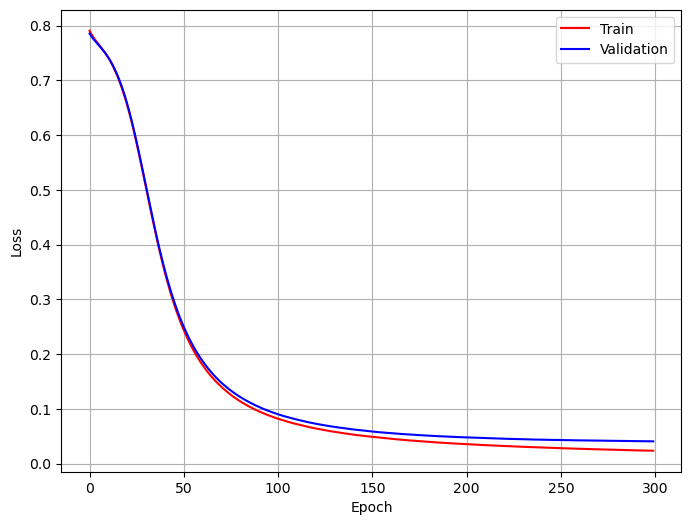

In [82]:
plt.figure(figsize=(8, 6))

plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

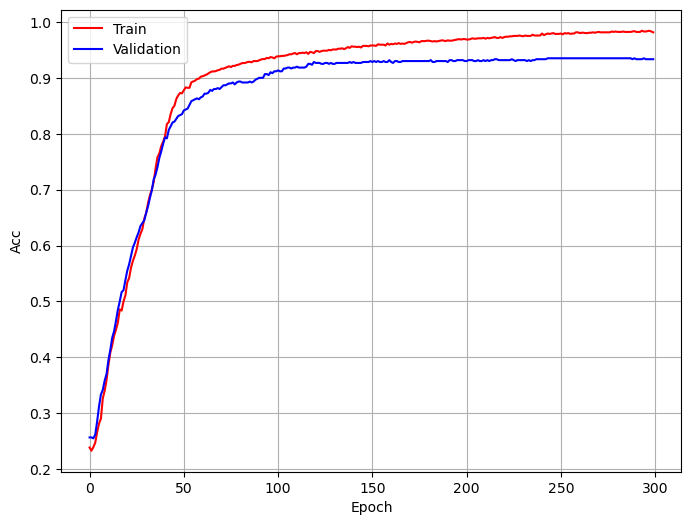

In [83]:
plt.figure(figsize=(8, 6))

plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()